### Basic Import:

In [1]:
from pathlib import Path
import pytorch_lightning as pl
import torch.nn as nn
import torch.optim as optim
from torchmetrics import MeanMetric
import numpy as np

from data_loader import *
from util_io import *
from metric import compute_iou, compute_dice


class SegmentationModel(pl.LightningModule):
    def __init__(self, model, learning_rate=1e-4, weight_decay=1e-5, gradient_clip_val=1.0):
        super(SegmentationModel, self).__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.gradient_clip_val = gradient_clip_val

        # Use CrossEntropyLoss for segmentation (expects long-type labels)
        self.criterion = nn.CrossEntropyLoss()

        # Define metrics
        self.train_loss_metric = MeanMetric()
        self.val_loss_metric = MeanMetric()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        image, label = batch  # Image: (N, C, H, W), Label: (N, H, W)
        logits = self(image)  # Model output: (N, C, H, W)

        # Ensure label is of type long for CrossEntropyLoss
        label = label.long()

        loss = self.criterion(logits, label)  # Compute CrossEntropyLoss
        self.train_loss_metric.update(loss)

        self.log("train_loss", self.train_loss_metric, prog_bar=True, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        image, label = batch
        logits = self(image)

        label = label.long()
        loss = self.criterion(logits, label)

        self.val_loss_metric.update(loss)
        self.log("val_loss", self.val_loss_metric, prog_bar=True, on_step=False, on_epoch=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        image, label = batch
        logits = self(image)  # Forward pass
        label = label.long()  # Ensure labels are the correct type
        
        mean_dice, per_class_dice = compute_dice(logits, label, num_classes=3)
        mean_iou, per_class_iou = compute_iou(logits, label, num_classes=3)
        self.log("mean_dice", mean_dice, prog_bar=True, on_step=False, on_epoch=True)
        return [per_class_dice, per_class_iou]
    

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        return optimizer

Seed set to 42


## Data loading

In [2]:
data_module = MemmapDataModule(
    train_path="./Data/dataset_train.npy",
    val_path="./Data/dataset_val.npy",
    test_path="./Data/dataset_test.npy",
    train_shape=(550, 2, 1024, 1024),
    val_shape=(220, 2, 1024, 1024),
    test_shape=(330, 2, 1024, 1024),
    batch_size=4,
    num_workers=4
)

data_module.setup()

# Check train loader
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()
test_loader = data_module.test_dataloader()

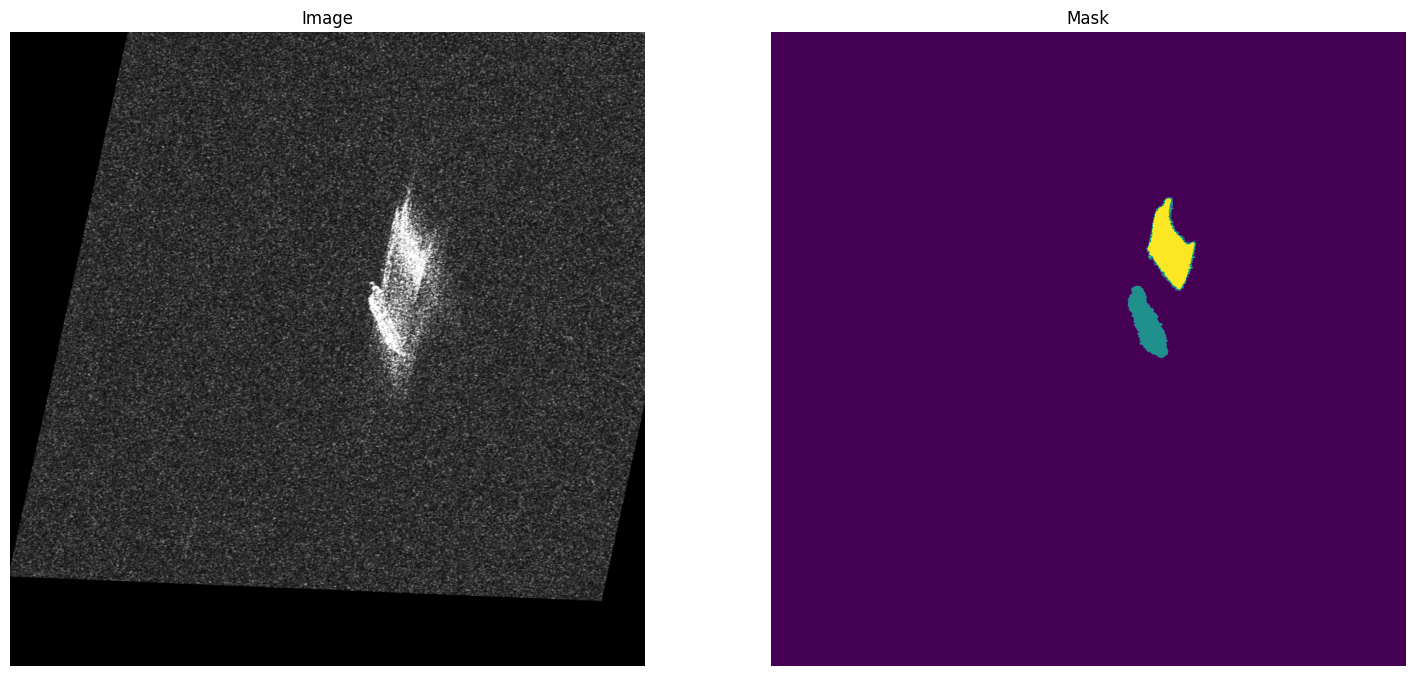

[0 1 2]


In [19]:
from plotty import display_batch
# Fetch a batch from the train_loader
data_batch = next(iter(train_loader))
display_batch(data_batch)


# TRAINING

In [10]:
import os
import random
import numpy as np
import torch
import pytorch_lightning as pl
import tqdm
from segmentation_models_pytorch import Unet, UnetPlusPlus, DeepLabV3, DeepLabV3Plus

model = Unet(in_channels=1, encoder_name="resnet18", classes=3)
model = SegmentationModel(model, learning_rate=1e-4)

Save, load and test the trained model

In [11]:
from pytorch_lightning.loggers import CSVLogger

epochs = 20
csv_logger = CSVLogger("logs", name=f"segmentation_model_e{epochs}")

trainer = pl.Trainer(
    max_epochs=epochs,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1, 
    logger=csv_logger,
)

trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: logs/segmentation_model_e20
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type             | Params | Mode 
---------------------------------------------------------------
0 | model             | Unet             | 14.3 M | train
1 | criterion         | CrossEntropyLoss | 0      | train
2 | train_loss_metric | MeanMetric       | 0      | train
3 | val_loss_metric   | MeanMetric       | 0      | train
---------------------------------------------------------------
14.3 M    

Epoch 19: 100%|██████████| 138/138 [00:27<00:00,  5.07it/s, v_num=0, val_loss=0.0106, train_loss_epoch=0.00824]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 138/138 [00:27<00:00,  5.01it/s, v_num=0, val_loss=0.0106, train_loss_epoch=0.00824]


In [12]:
# Save model weights after training'
save_model(model, 'model_weights.pth')

Model weights saved at model_weights.pth


In [13]:
model = load_model(model, 'model_weights.pth')

Model weights loaded from model_weights.pth


In [14]:
test_result = trainer.test(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 83/83 [00:04<00:00, 20.34it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         mean_dice         │    0.8764135241508484     │
└───────────────────────────┴───────────────────────────┘

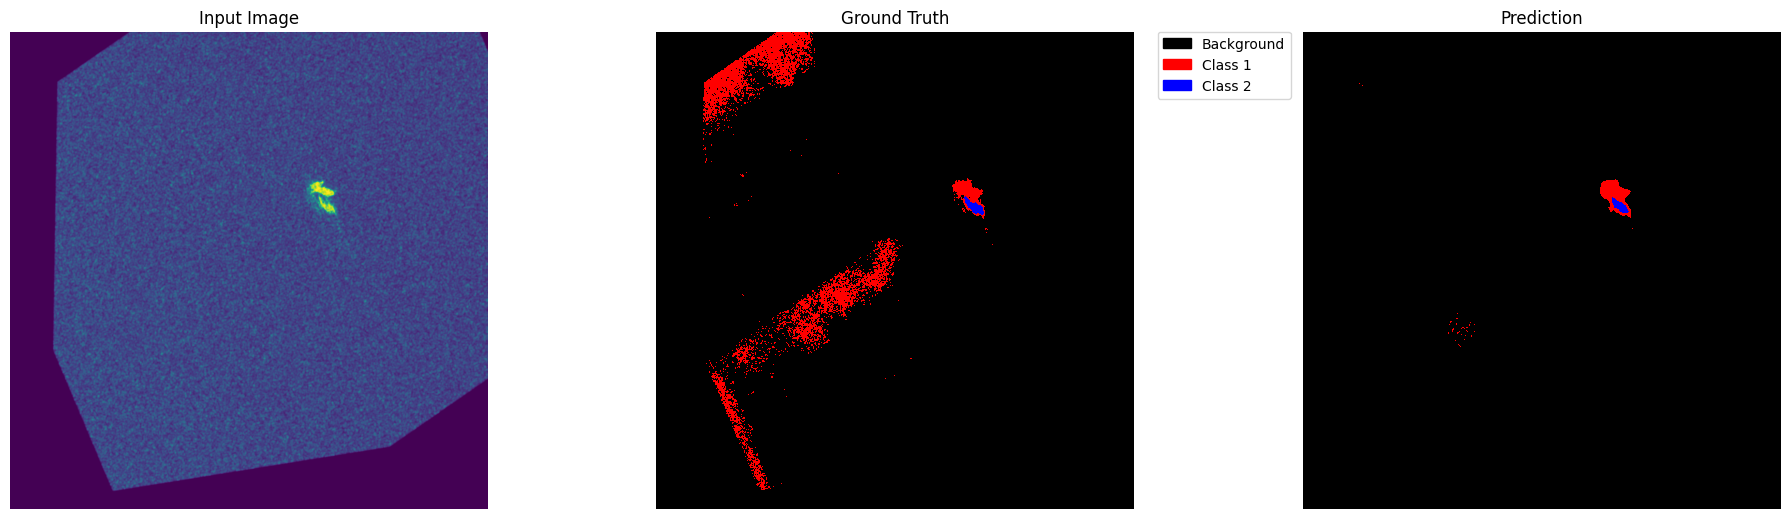

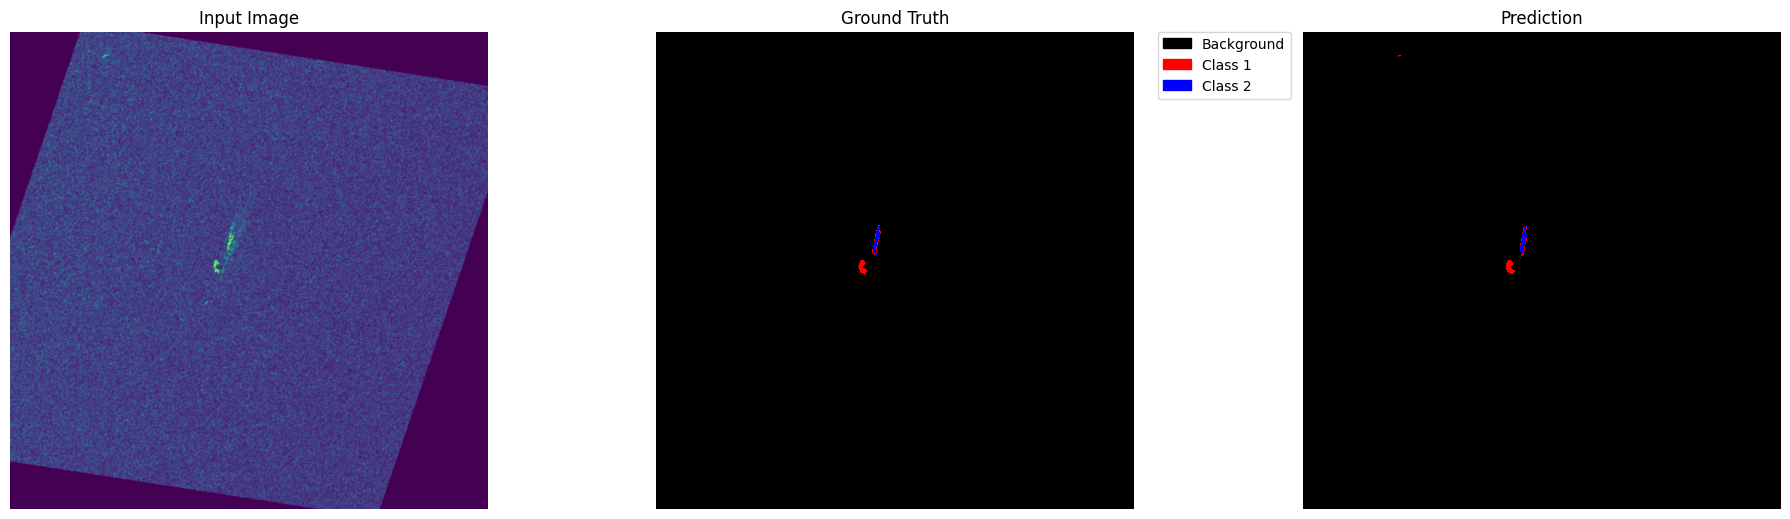

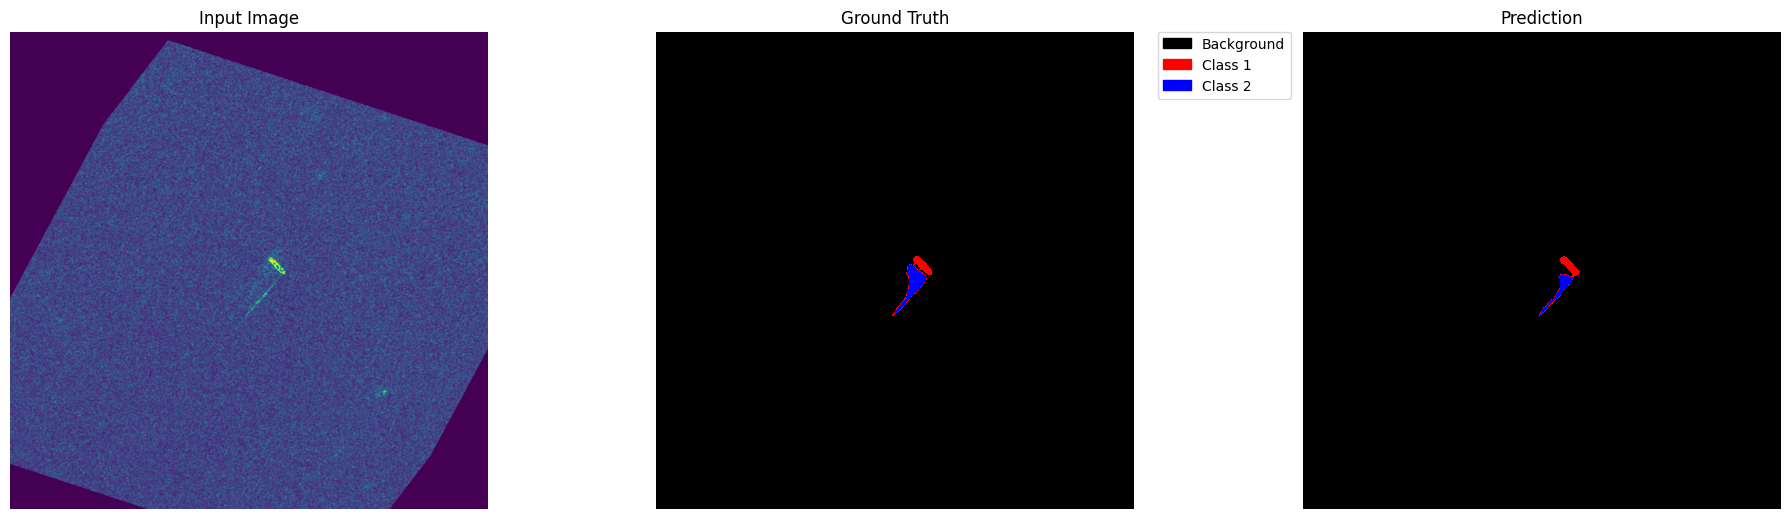

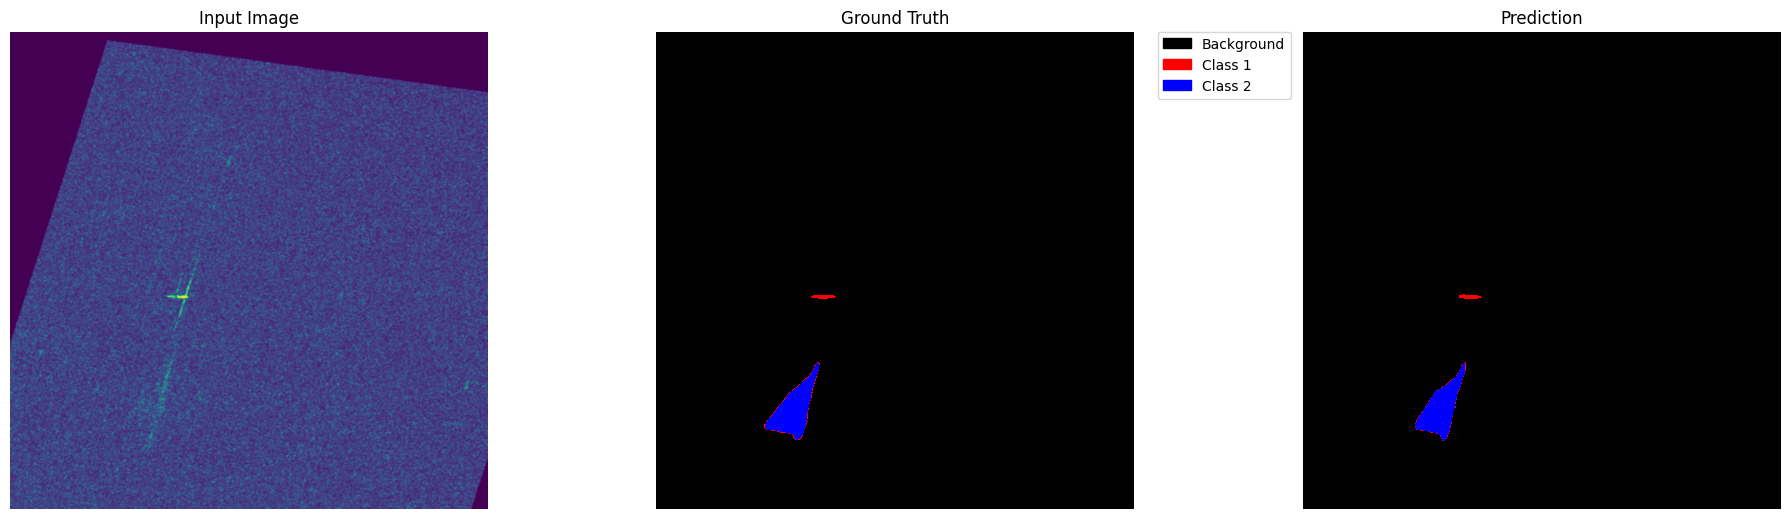

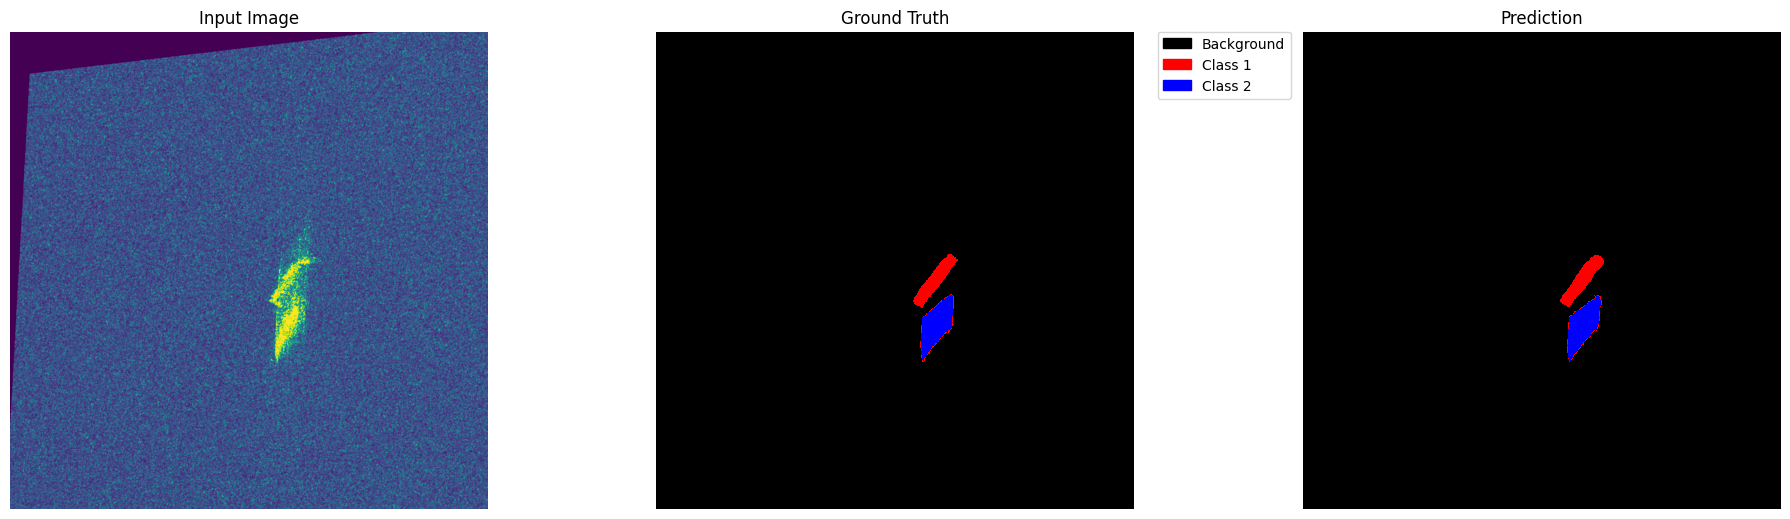

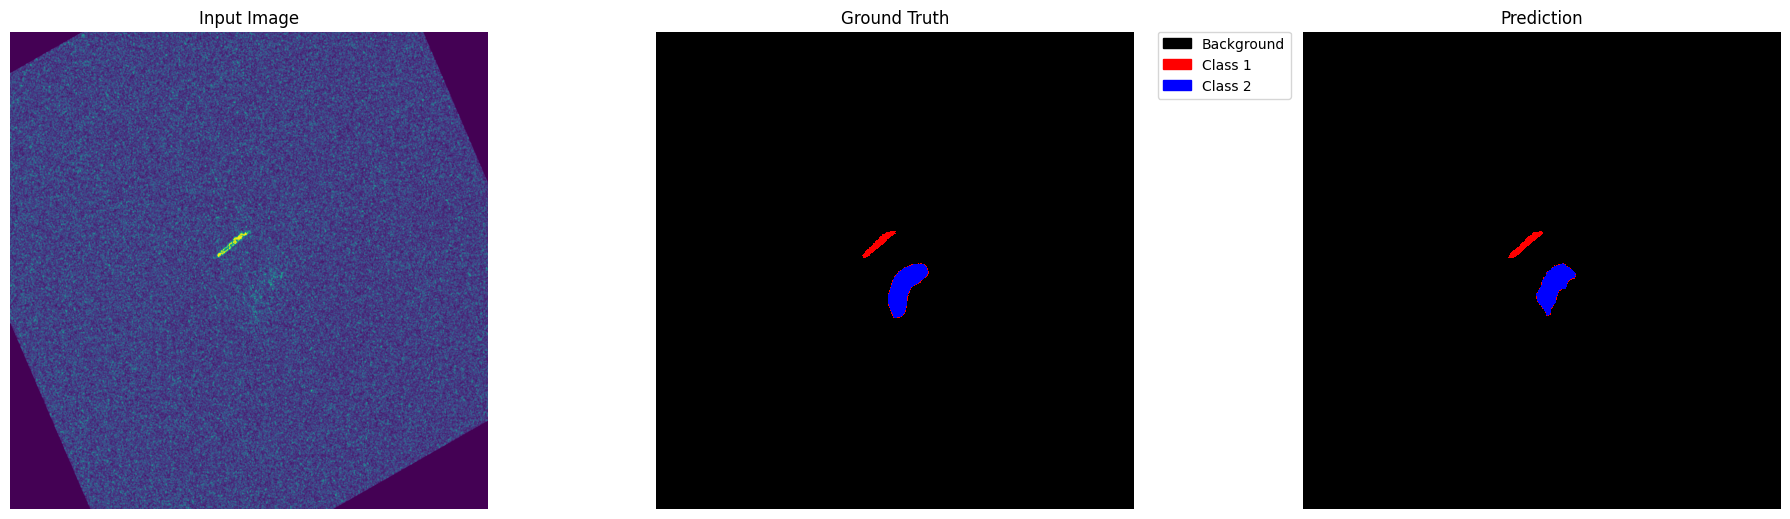

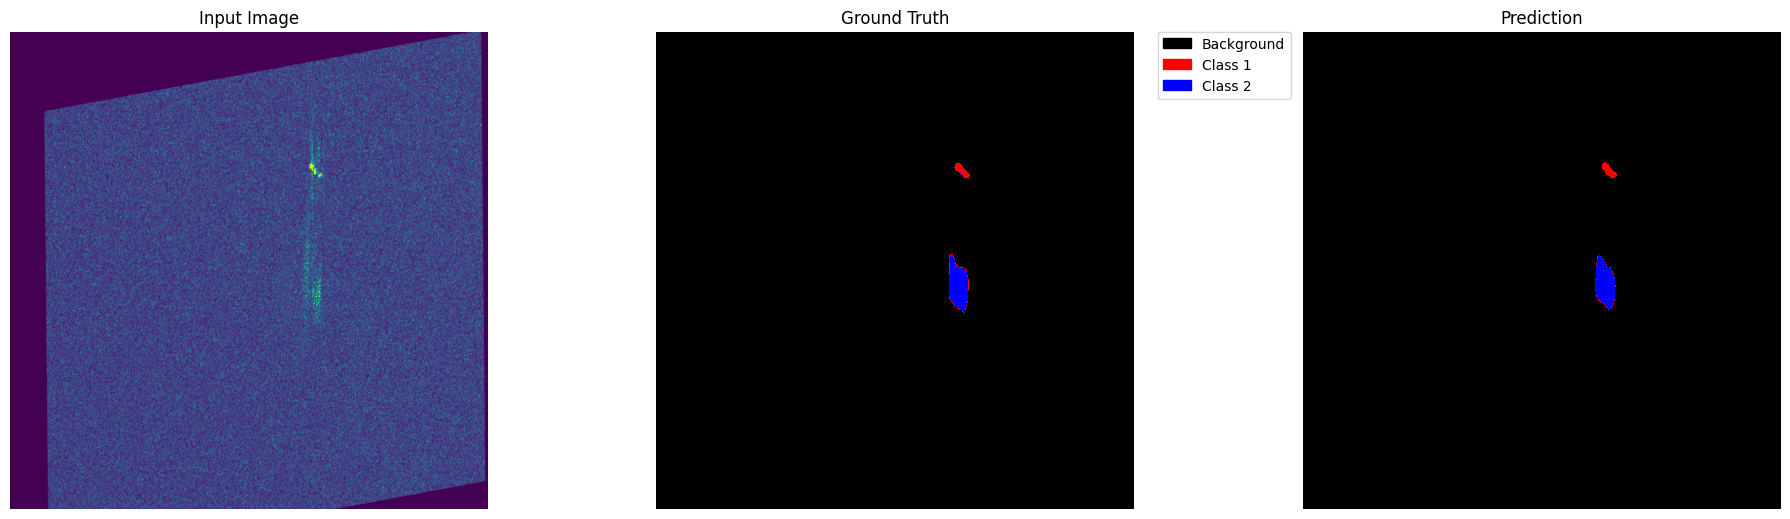

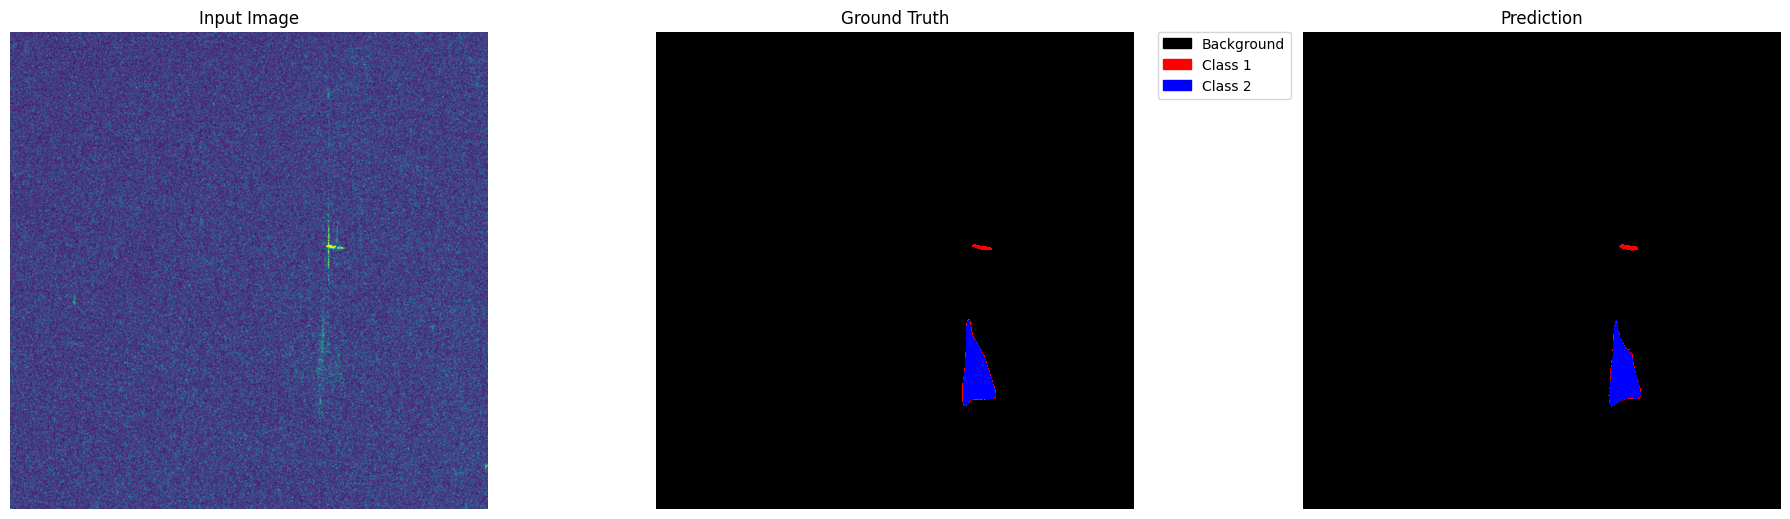

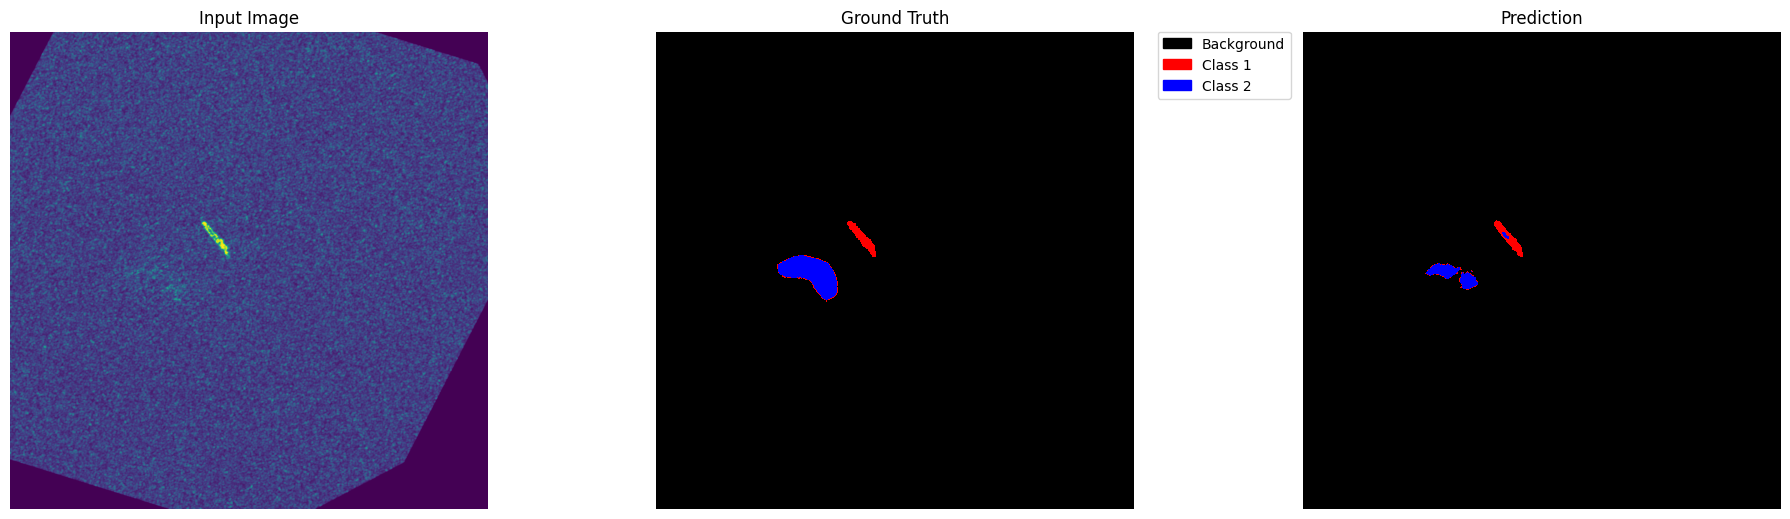

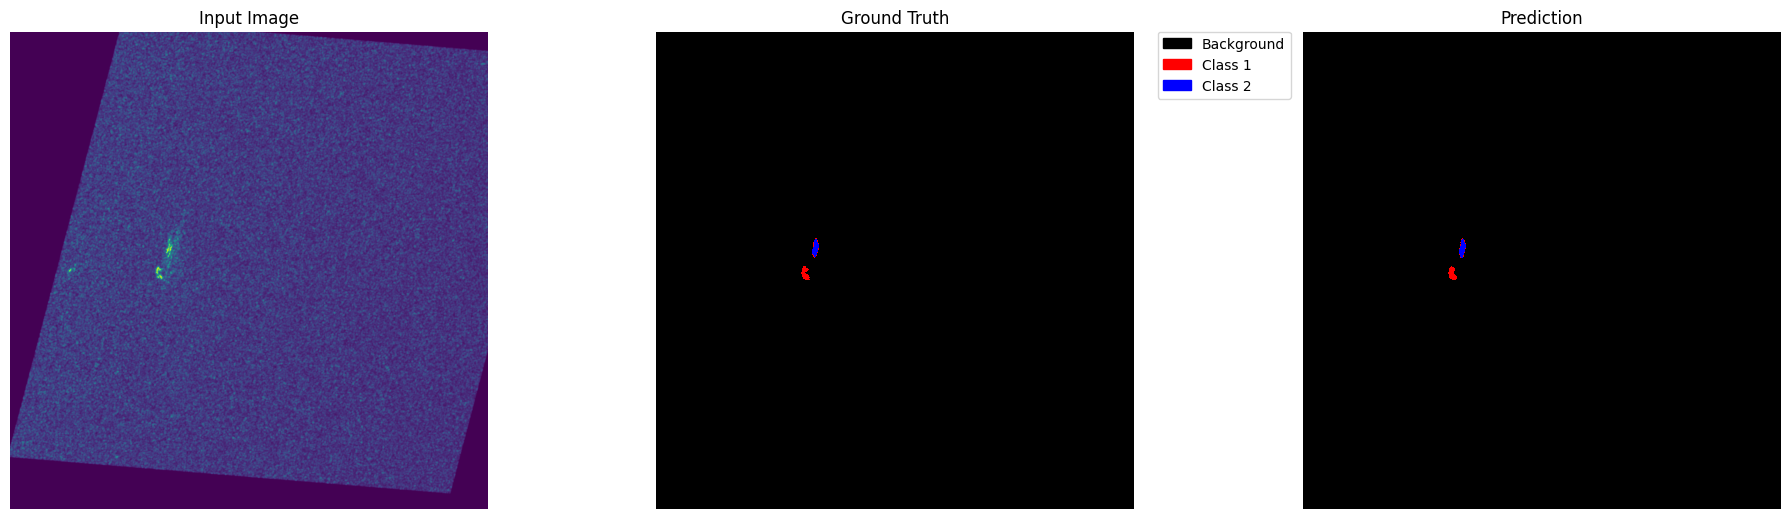

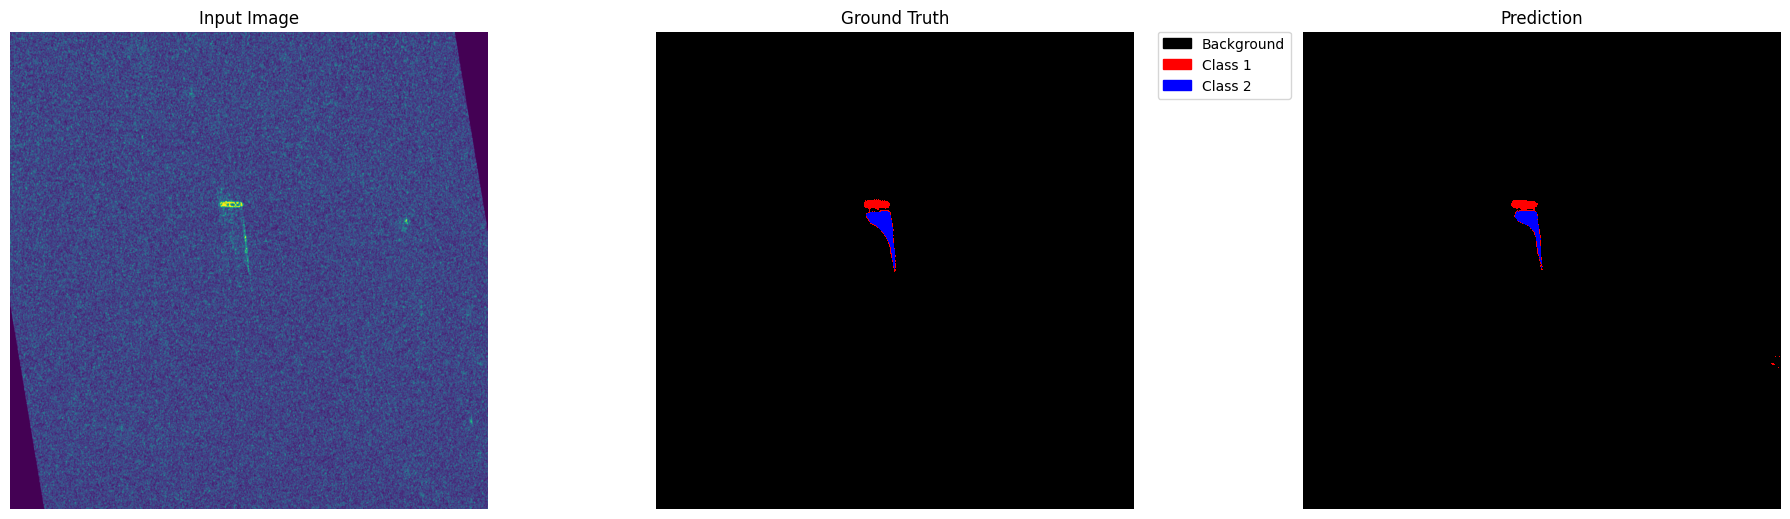

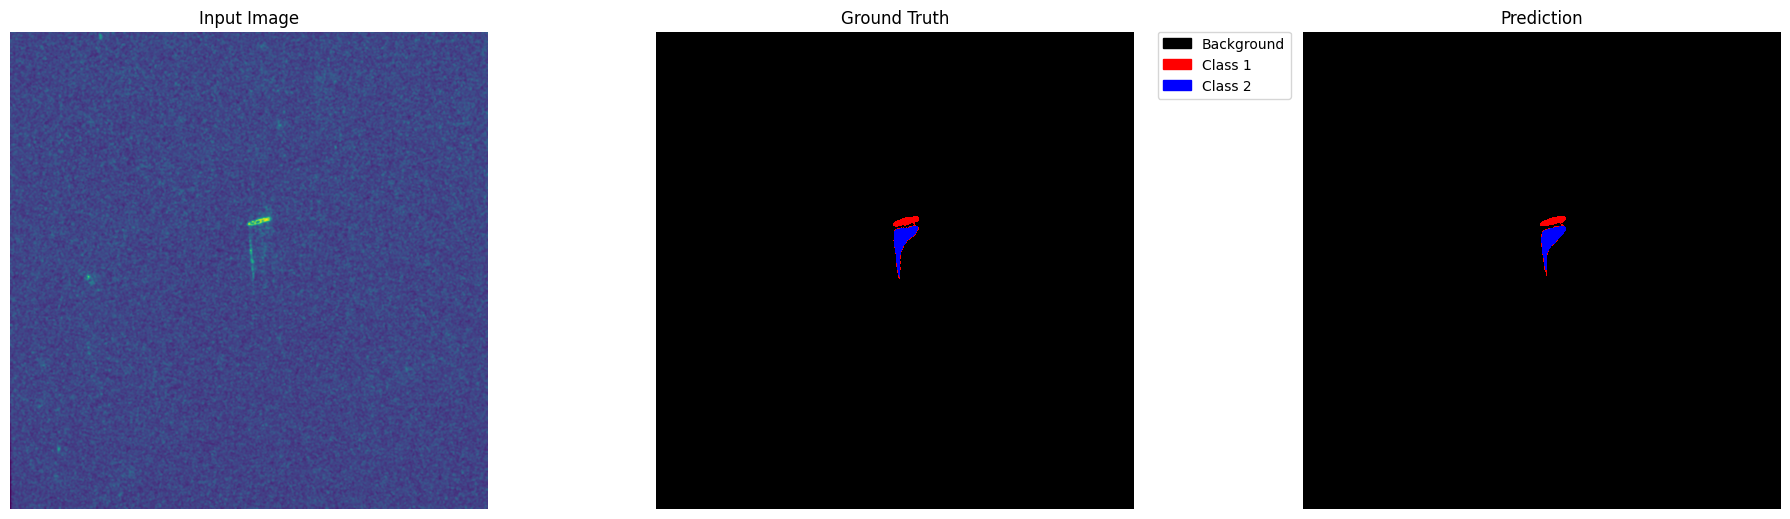

In [22]:
import torch
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

# --- Configuration: adjust these for your dataset ---
num_classes = 3  # for example, background + 3 classes
colors = ["black", "red", "blue"]  # colors for each class (normalized names or RGB tuples)
class_labels = ["Background", "Class 1", "Class 2"]

# Create a discrete colormap for segmentation maps.
cmap = mcolors.ListedColormap(colors)

# --- Inference and Visualization ---
# Ensure the model is in evaluation mode and on the correct device.
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Use torch.no_grad for inference.
with torch.no_grad():
    # Loop over the test loader (here, we process just one batch for demonstration)
    for idx, batch in enumerate(test_loader):
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass to get output logits.
        outputs = model(images)
        # Get predicted segmentation maps by taking argmax along the channel dimension.
        preds = torch.argmax(outputs, dim=1)  # shape: [B, H, W]

        # Process each sample in the batch.
        for i in range(images.size(0)):
            
            # Convert the image tensor [C, H, W] to a NumPy array [H, W, C] for plotting.
            img_np = images[i].cpu().permute(1, 2, 0).numpy()

            # Optionally unnormalize the image if it was normalized during training.
            # Example:
            # mean = [0.485, 0.456, 0.406]
            # std = [0.229, 0.224, 0.225]
            # img_np = std * img_np + mean
            # img_np = img_np.clip(0, 1)

            # Get ground truth and prediction segmentation maps.
            gt_np = labels[i].cpu().numpy()
            pred_np = preds[i].cpu().numpy()

            # Create a figure with 3 subplots.
            fig, axes = plt.subplots(1, 3, figsize=(18, 6))

            # Input image.
            axes[0].imshow(img_np)
            axes[0].set_title("Input Image")
            axes[0].axis("off")

            # Ground Truth with discrete colormap.
            im_gt = axes[1].imshow(gt_np, cmap=cmap, vmin=0, vmax=num_classes - 1)
            axes[1].set_title("Ground Truth")
            axes[1].axis("off")

            # Prediction with discrete colormap.
            im_pred = axes[2].imshow(pred_np, cmap=cmap, vmin=0, vmax=num_classes - 1)
            axes[2].set_title("Prediction")
            axes[2].axis("off")

            # Create legend patches for the classes.
            patches = [mpatches.Patch(color=colors[j], label=class_labels[j]) for j in range(num_classes)]
            # Optionally, add the legend to one of the subplots.
            axes[1].legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

            plt.tight_layout()
            plt.show()

        # Process only the first batch; remove break to process more.
        if idx == 2:
            break